### aim: 

### date: 

In [142]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [143]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [144]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

Text(0.5, 0.98, 'ocean regions, subdivided, with atlantic mask (rh side modified for easier transports)')

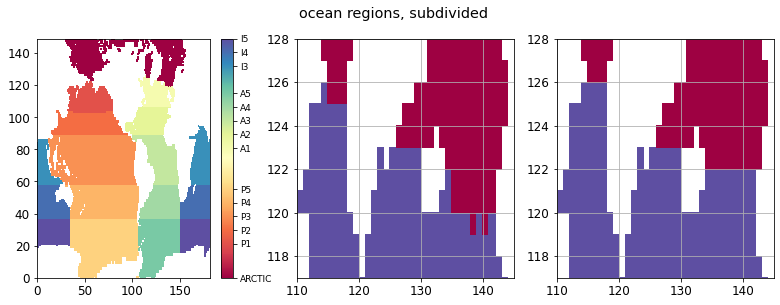

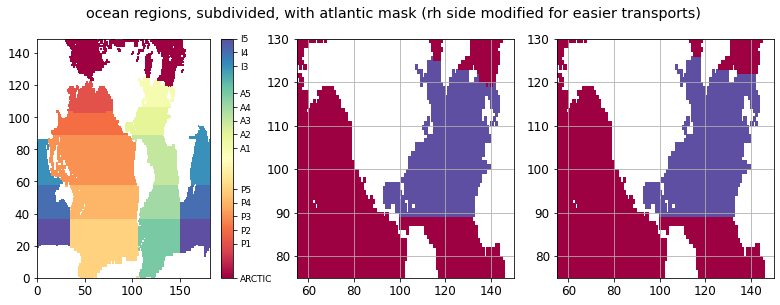

In [145]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

masknoATL = np.copy(maskno)

masknoATL[np.where(masknoATL == 2.6) ]= 5
masknoATL[np.where(masknoATL == 2.4) ]= 5
masknoATL[masknoATL < 5] = 0

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoATL, cmap = tcm, vmin = 0.5, vmax = 4)

axs[1].set_xlim([55,150])
axs[1].set_ylim([75,130])
axs[1].set_xlim([110,145])
axs[1].set_ylim([117,128])
axs[1].grid()

###here is the transport boundary fix
masknoATLnb = np.copy(masknoATL)
masknoATLnb[118:122,130:144] = 5
masknoATLnb[125:126,110:120] = 5
nan_mask = np.isnan(masknoATL)
masknoATLnb[nan_mask] = np.nan
w = axs[2].pcolor(masknoATLnb, cmap = tcm, vmin = 0.5, vmax = 4)
axs[2].set_xlim([110,145])
axs[2].set_ylim([117,128])
axs[2].grid()

fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoATL, cmap = tcm, vmin = 0.5, vmax = 4)

axs[1].set_xlim([55,150])
axs[1].set_ylim([75,130])
axs[1].grid()

w = axs[2].pcolor(masknoATLnb, cmap = tcm, vmin = 0.5, vmax = 4)
axs[2].set_xlim([55,150])
axs[2].set_ylim([75,130])
axs[2].grid()


#masknoATLnb[]
plt.suptitle('ocean regions, subdivided, with atlantic mask (rh side modified for easier transports)')



## identify borders for lateral transport: newfoundland-greenland (N1), greenland-iceland (N2), iceland-norway (N3) and the southern border (S1)

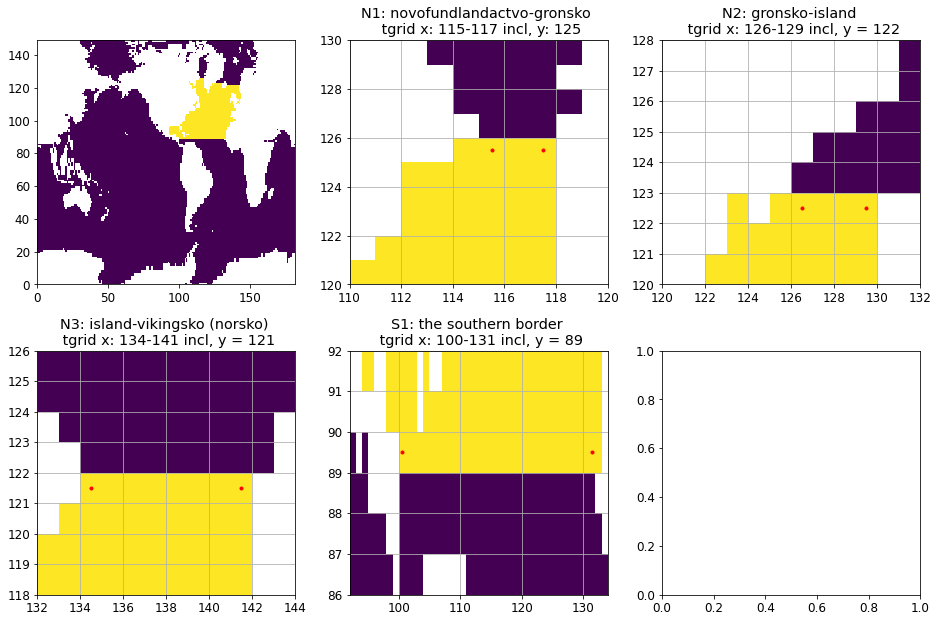

In [146]:
tm = masknoATLnb

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].pcolormesh(tm)

axs[1].pcolormesh(tm)
axs[1].set_title('N1: novofundlandactvo-gronsko \n tgrid x: 115-117 incl, y: 125')
axs[1].pcolormesh(tm); axs[1].set_xlim([110,120]); axs[1].set_ylim([120,130])
axs[1].plot(115.5,125.5,'r.')
axs[1].plot(117.5,125.5,'r.')
#newfoundland boundary: x: 115,116,117 y:125

ind = 2
axs[ind].set_title('N2: gronsko-island \n tgrid x: 126-129 incl, y = 122')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([120,132]); axs[ind].set_ylim([120,128])
axs[ind].plot(126.5,122.5,'r.');axs[ind].plot(129.5,122.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 3
axs[ind].set_title('N3: island-vikingsko (norsko) \n tgrid x: 134-141 incl, y = 121')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([132,144]); axs[ind].set_ylim([118,126])
axs[ind].plot(134.5,121.5,'r.');axs[ind].plot(141.5,121.5,'r.')
#gronsko boundary: x: 134-141 inclusive, y = 121

ind = 4
axs[ind].set_title('S1: the southern border \n tgrid x: 100-131 incl, y = 89')
axs[ind].pcolormesh(tm); axs[ind].set_xlim([92,134]); axs[ind].set_ylim([86,92])
axs[ind].plot(100.5,89.5,'r.');axs[ind].plot(131.5,89.5,'r.')

#gronsko boundary: x: 134-141 inclusive, y = 121


for i in range(1,5):
    
    axs[i].grid()
    
plt.tight_layout()

we now want transport across each of these boundaries. the v grid and the t grid are offset, so let's look at that:

In [147]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/'

tgrid = xr.open_dataset(f'{tdir}ORCA2_1m_19600101_19601231_ptrc_T.nc')
vgrid = xr.open_dataset(f'{tdir}ORCA2_1m_19600101_19601231_grid_V.nc')

tgrid

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 12, x: 182, y: 149)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1960-01-16 12:00:00 ... 1960-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/30)
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    Alkalini              (time_counter, deptht, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    O2                    (time_counter, deptht, y, x) float32 ...
    DIC                   (time_counter, deptht, y, x) float32 ...
    ...                    ...
    COC                   (time_counter, deptht, y, x) float32 ...
    PIC                   (time_counter, deptht, y, x) float32 ...
    PHA                   (time_counter, deptht, y, x) float32 ...
    FIX                   (time_counter, deptht, y, x) float32 ...
    BSi                   (time_counter, deptht, y, x) float32 ...
    GON                   (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         ORCA2_1m_19600101_19601231
    description:  planktom sms variables
    title:        planktom sms variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2023-Aug-22 17:18:02 BST

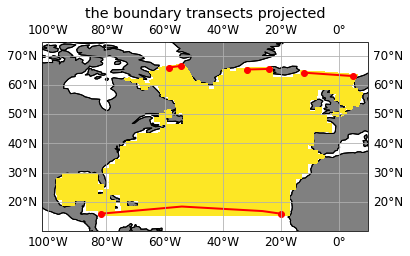

In [153]:

fact = 0.8
tfig = plt.figure(figsize=[10.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder = 0 )
#lons, lats extent
ax.set_extent([ -102, 10, 10, 75,], crs=ccrs.PlateCarree())

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
tm2 = np.copy(tm)
tm2[tm == 0] = np.nan
mesh = ax.pcolormesh(nav_lon, nav_lat, tm2, transform=ccrs.PlateCarree(), cmap='viridis_r')
#plt.colorbar(mesh, orientation = 'horizontal', label = 'rho')
ax.add_feature(cp.feature.LAND, color='grey')

N1start_lat, N1start_lon = nav_lat[125, 115], nav_lon[125, 115]
N1end_lat, N1end_lon = nav_lat[125, 117], nav_lon[125, 117]
ax.plot([N1start_lon, N1end_lon], [N1start_lat, N1end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())


N2start_lat, N2start_lon = nav_lat[122, 126], nav_lon[122, 126]
N2end_lat, N2end_lon = nav_lat[122, 129], nav_lon[122, 129]
ax.plot([N2start_lon, N2end_lon], [N2start_lat, N2end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

N3start_lat, N3start_lon = nav_lat[121, 134], nav_lon[121, 134]
N3end_lat, N3end_lon = nav_lat[121, 141], nav_lon[121, 141]
ax.plot([N3start_lon, N3end_lon], [N3start_lat, N3end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

S1start_lat, S1start_lon = nav_lat[89, 100], nav_lon[89, 100]
S1end_lat, S1end_lon = nav_lat[89, 131], nav_lon[89, 131]
ax.plot([S1start_lon, S1end_lon], [S1start_lat, S1end_lat], color='red', \
        linewidth=2, marker='o', transform=ccrs.Geodetic())

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.coastlines(zorder = 0 )
plt.title('the boundary transects projected')
plt.tight_layout()
plt.show()

[64.87694 64.77734]
[64.304   64.20609]
[63.727394 63.631203]


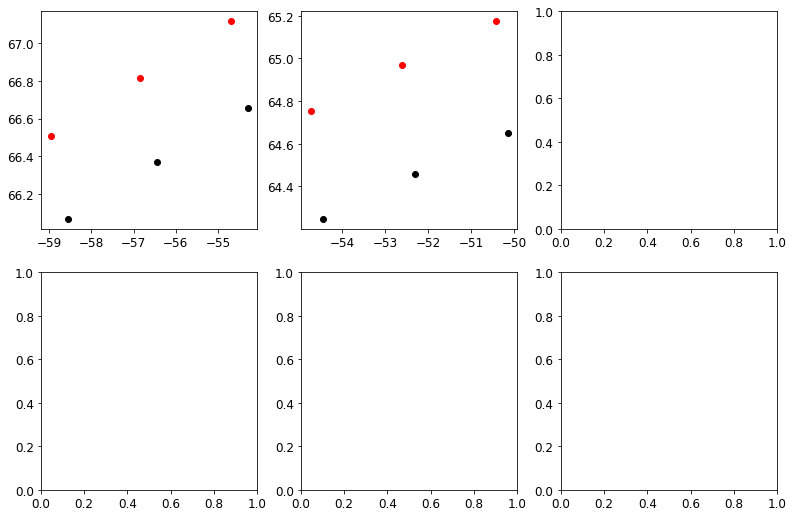

In [154]:
print(vgrid['nav_lat'][121,134:136].values)
print(tgrid['nav_lat'][121,134:136].values)
print(vgrid['nav_lat'][120,134:136].values)

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#axs[0].pcolormesh(tm)
for i in range(0,3):
    axs[0].scatter(vgrid['nav_lon'][125,115+i],vgrid['nav_lat'][125,115+i],marker = 'o', color = 'r')
    axs[0].scatter(tgrid['nav_lon'][125,115+i],tgrid['nav_lat'][125,115+i],marker = 'o', color = 'k')
    
for i in range(0,3):
    axs[1].scatter(vgrid['nav_lon'][122,116+i],vgrid['nav_lat'][122,119+i],marker = 'o', color = 'r')
    axs[1].scatter(tgrid['nav_lon'][122,116+i],tgrid['nav_lat'][122,119+i],marker = 'o', color = 'k')

In [155]:
tmask

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): X(182), Y(149)
    variables(dimensions): float32 X(Y,X), float32 Y(Y,X), float32 ATL(Y,X), float32 PAC(Y,X), float32 IND(Y,X), float32 SO(Y,X), float32 ARCTIC(Y,X), float32 P1(Y,X), float32 P2(Y,X), float32 P3(Y,X), float32 P4(Y,X), float32 P5(Y,X), float32 A1(Y,X), float32 A2(Y,X), float32 A3(Y,X), float32 A4(Y,X), float32 A5(Y,X), float32 I3(Y,X), float32 I4(Y,X), float32 I5(Y,X)
    groups: 

In [171]:
y = 125; x1 = 115; x2 = 117

def get_mask(x1,x2,y):
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    vmask = tmesh['vmask'][0,:,y,:]
    e3v = tmesh['e3v_0'][0,:,y,:]
    e1v = (tmesh.e1v[0,y,:])
    e1vb = np.zeros([31,182])
    for i in range(0,31):
       e1vb[i,:] =  e1v
    csize_N1 = vmask*e1vb*e3v
    
    csize_N1[:,0:x1] = 0
    csize_N1[:,x2+1:-1]=0
    csize_N1v = np.copy(csize_N1)
    csize_N1v[np.where(csize_N1 < 1)] = np.nan
    
    return csize_N1v


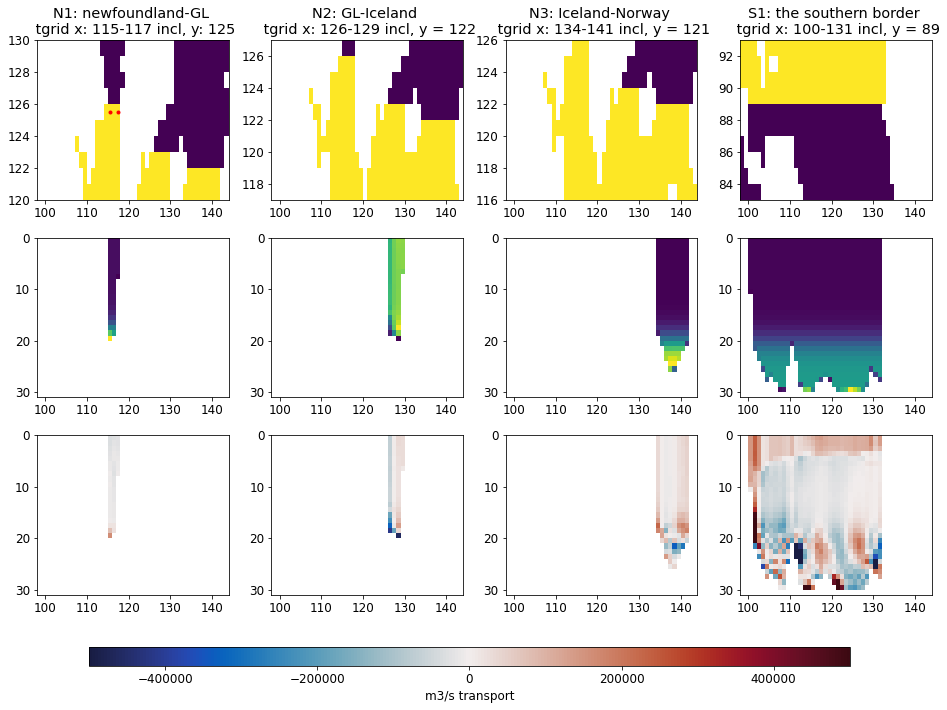

In [309]:
tm = masknoATLnb

fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


ind = 0
axs[ind].set_title('N1: newfoundland-GL \n tgrid x: 115-117 incl, y: 125')
y = 125; x1 = 115; x2 = 117
axs[ind].pcolormesh(tm)
axs[ind].pcolormesh(tm); axs[ind].set_xlim([x1-5,x2+5]); axs[ind].set_ylim([y-5,y+5])
axs[ind].plot(115.5,125.5,'r.')
axs[ind].plot(117.5,125.5,'r.')
csize_N1v = get_mask(x1,x2,y)
axs[ind+4].pcolormesh(csize_N1v)
axs[ind+4].set_xlim([x1-5,x2+5]);

#newfoundland boundary: x: 115,116,117 y:125

ind = 1
y = 122; x1 = 126; x2 = 129
axs[ind].set_title('N2: GL-Iceland \n tgrid x: 126-129 incl, y = 122')
axs[ind].pcolormesh(tm)
axs[ind].pcolormesh(tm); axs[ind].set_xlim([x1-5,x2+5]); axs[ind].set_ylim([y-5,y+5])
csize_N2v = get_mask(x1,x2,y)
axs[ind+4].pcolormesh(csize_N2v)
axs[ind+4].set_xlim([x1-5,x2+5]);

#newfoundland boundary: x: 115,116,117 y:125

ind = 2
y = 121; x1=134; x2=141
axs[ind].set_title('N3: Iceland-Norway \n tgrid x: 134-141 incl, y = 121')
axs[ind].pcolormesh(tm)
axs[ind].pcolormesh(tm); axs[ind].set_xlim([x1-5,x2+5]); axs[ind].set_ylim([y-5,y+5])
csize_N3v = get_mask(x1,x2,y)
axs[ind+4].pcolormesh(csize_N3v)
axs[ind+4].set_xlim([x1-5,x2+5]);


ind = 3
#88 in v grid, as things into model
y = 88; x1=100; x2=131
axs[ind].set_title('S1: the southern border \n tgrid x: 100-131 incl, y = 89')
axs[ind].pcolormesh(tm)
axs[ind].pcolormesh(tm); axs[ind].set_xlim([x1-5,x2+5]); axs[ind].set_ylim([y-5,y+5])
csize_S1v = get_mask(x1,x2,y)
axs[ind+4].pcolormesh(csize_S1v)
axs[ind+4].set_xlim([x1-5,x2+5]);

#gronsko boundary: x: 134-141 inclusive, y = 121


y=125
axs[0+4].pcolormesh(csize_N1v)
axs[0+8].pcolormesh(csize_N1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=122
axs[1+4].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:])
axs[1+8].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=121
axs[2+4].pcolormesh(csize_N3v)
axs[2+8].pcolormesh(csize_N3v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=88
axs[3+4].pcolormesh(csize_S1v)
w = axs[3+8].pcolormesh(csize_S1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)


for i in range(4,12):
    
    axs[i].invert_yaxis()

for i in range(0,12):
    axs[i].set_xlim([98,144])
    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm3/s transport')
plt.tight_layout()


    
plt.tight_layout()

In [176]:
y = 89; x1=100; x2=131
csize_S1v = get_mask(x1,x2,y)
y = 88; x1=100; x2=131
csize_S2v = get_mask(x1,x2,y)

print(np.nanmean(csize_S1v-csize_S2v))
print(np.nanmax(csize_S1v-csize_S2v))

-1004398.0014734511
97063897.12191549


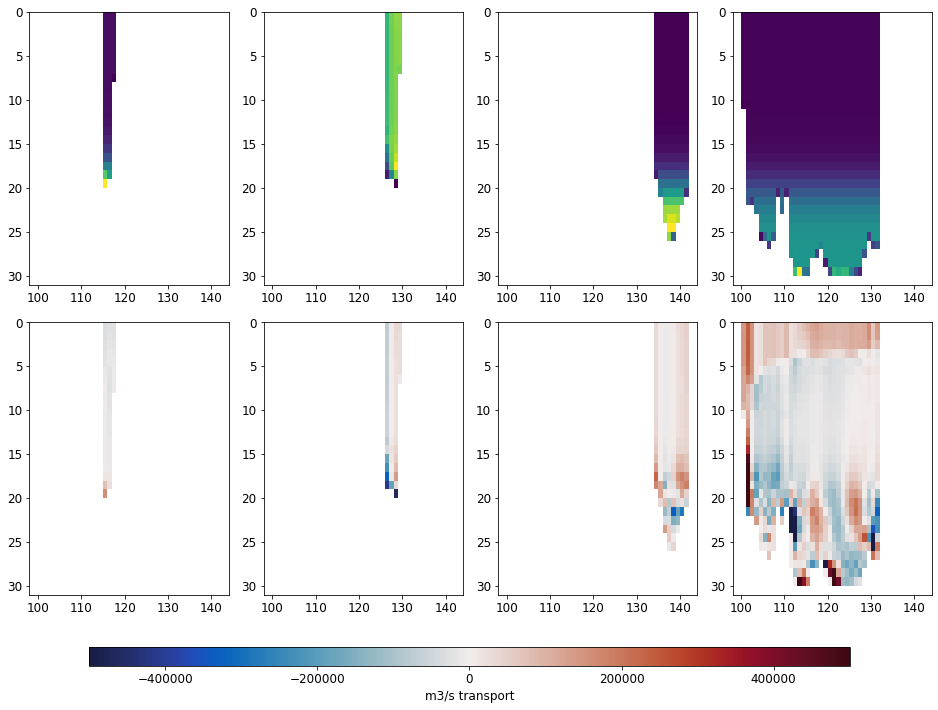

In [192]:
vgrid = xr.open_dataset(f'{tdir}ORCA2_1m_19600101_19601231_grid_V.nc')

fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmi = -5e5
tvma = 5e5

y=125
axs[0+4].pcolormesh(csize_N1v)
axs[0+8].pcolormesh(csize_N1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=122
axs[1+4].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:])
axs[1+8].pcolormesh(csize_N2v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=121
axs[2+4].pcolormesh(csize_N3v)
axs[2+8].pcolormesh(csize_N3v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)

y=88
axs[3+4].pcolormesh(csize_S1v)
w = axs[3+8].pcolormesh(csize_S1v*vgrid.vomecrty[0,:,y,:], cmap = cm.balance, vmin = tvmi, vmax = tvma)


for i in range(4,12):
    
    axs[i].invert_yaxis()
    axs[i].set_xlim([98,144])
    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm3/s transport')
plt.tight_layout()

vgrid.e3v[:,10,122,126]

In [ ]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

masknoATLnb2 = np.copy(masknoATLnb)
masknoATLnb2[np.where(masknoATLnb>1)]=1
masknoATLnb2[np.where(masknoATLnb!=5)]=0
plt.pcolormesh(masknoATLnb2)


ATLbroad = np.zeros([31,149,182])
for i in range(0,31):
    ATLbroad[i,:,:] = masknoATLnb2 * tmesh.e1t[0,:,:].values * tmesh.e2t[0,:,:].values * tmesh.e3t_0[0,i,:,:].values
    
atlvol = (np.nansum(ATLbroad))
formatted_number = f"{atlvol:.3e}"
print(formatted_number)

-1.634007065107112

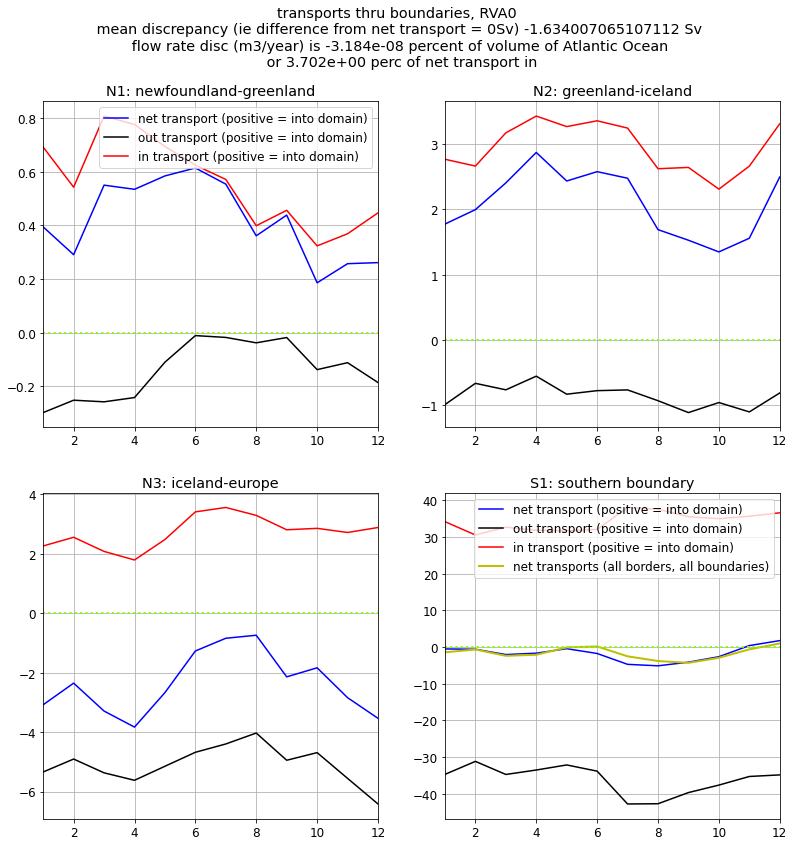

In [304]:
fact = 1.1


N1n = np.zeros([12,3])
N2n = np.zeros([12,3])
N3n = np.zeros([12,3])
S1n = np.zeros([12,3])
#positive is out of domain

for i in range(0,12):
    
    N1sv = (csize_N1v*vgrid.vomecrty[i,:,125,:].values)*-1 #positive is out of domain

    N2sv = (csize_N2v*vgrid.vomecrty[i,:,122,:].values)*-1 #positive is out of domain

    N3sv = (csize_N3v*vgrid.vomecrty[i,:,121,:].values)*-1 #positive is out of domain

    S1sv = (csize_S1v*vgrid.vomecrty[i,:,88,:].values)

    N1n[i,0] = np.nansum(N1sv)
    N1n[i,1] = np.nansum(N1sv[np.where(N1sv<0)])
    N1n[i,2] = np.nansum(N1sv[np.where(N1sv>=0)])
    
    N2n[i,0] = np.nansum(N2sv)
    N2n[i,1] = np.nansum(N2sv[np.where(N2sv<0)])
    N2n[i,2] = np.nansum(N2sv[np.where(N2sv>=0)])
    
    N3n[i,0] = np.nansum(N3sv)
    N3n[i,1] = np.nansum(N3sv[np.where(N3sv<0)])
    N3n[i,2] = np.nansum(N3sv[np.where(N3sv>=0)])
    
    S1n[i,0] = np.nansum(S1sv)
    S1n[i,1] = np.nansum(S1sv[np.where(S1sv<0)])
    S1n[i,2] = np.nansum(S1sv[np.where(S1sv>=0)])
    
mos = np.arange(1,13,1)
fig, axs = plt.subplots(2,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs[0].plot(mos,N1n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[0].plot(mos,N1n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[0].plot(mos,N1n[:,2]/1e6, 'r-', label ='in transport (positive = into domain)')

ind = 1
axs[ind].plot(mos,N2n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,N2n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,N2n[:,2]/1e6, 'r-', label ='int transport (positive = into domain)')

ind = 2
axs[ind].plot(mos,N3n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,N3n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,N3n[:,2]/1e6, 'r-', label ='int transport (positive = into domain)')

ind = 3
axs[ind].plot(mos,S1n[:,0]/1e6, 'b-', label ='net transport (positive = into domain)')
axs[ind].plot(mos,S1n[:,1]/1e6, 'k-', label ='out transport (positive = into domain)')
axs[ind].plot(mos,S1n[:,2]/1e6, 'r-', label ='in transport (positive = into domain)')

tots = S1n[:,0]/1e6 + N1n[:,0]/1e6 + N2n[:,0]/1e6 + N3n[:,0]/1e6
axs[3].plot(mos, tots, 'y-', linewidth = 2, label = 'net transports (all borders, all boundaries)')
disc = np.nanmean(tots)


siy = 60*60*24*365.25

axs[0].legend(loc = 'best')
axs[3].legend(loc = 'best')

axs[0].set_title('N1: newfoundland-greenland')
axs[1].set_title('N2: greenland-iceland')
axs[2].set_title('N3: iceland-europe')
axs[3].set_title('S1: southern boundary')

for i in range(0,4):
    axs[i].set_xlim([1,12])
    axs[i].grid([1,12])
    axs[i].axhline(y=0, linestyle = ':', color = 'chartreuse', linewidth = 2)
    
perc = disc*siy/atlvol*100
percf = f"{perc:.3e}"
disct = (np.nanmean(tots/((N1n[:,1]+N2n[:,1]+N3n[:,1]+S1n[:,1])/1e6))*100)
disctf = f"{disct:.3e}"

plt.suptitle(f'transports thru boundaries, RVA0 \n mean discrepancy (ie difference from net transport = 0Sv) {disc} Sv \n flow rate disc (m3/year) is {percf} percent of volume of Atlantic Ocean \n or {disctf} perc of net transport in')
np.nanmean(tots)